## AeroSense Data Analysis
- The following includes some exploratory data anlaysis and modeling of Orchard records regarding the Aerosol Sense observations from May 2021 - present.

In [582]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [583]:
aero = pd.read_csv('Aero_01.csv')

In [584]:
aero.head()

,Patient MRN,Collection Date,Sample ID,Result,Result Approval Date
0,ET-01,05/25/2021 4:54PM,AE00000F6F1B48,SARS-CoV-2 Not Detected,05/26/2021 12:45PM
1,ET-03,05/25/2021 7:12PM,AE00000F6D7142,SARS-CoV-2 Not Detected,05/26/2021 12:44PM
2,ET-03,05/25/2021 7:14PM,AE00000F6C063F,SARS-CoV-2 Not Detected,05/26/2021 12:44PM
3,ET-03,05/25/2021 7:16PM,AE00000F6BFF5C,SARS-CoV-2 Not Detected,05/26/2021 12:45PM
4,ET-01,05/26/2021 9:07PM,AE00000F6C9042,SARS-CoV-2 Not Detected,05/27/2021 6:29AM


In [585]:
aero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Patient MRN           819 non-null    object
 1   Collection Date       819 non-null    object
 2   Sample ID             819 non-null    object
 3   Result                819 non-null    object
 4   Result Approval Date  819 non-null    object
dtypes: object(5)
memory usage: 32.1+ KB


### Notes:
- no missing values, all object
- convert date/time for collection and resulted
- Patient MRN to unit number
- Result to categorical

In [586]:
aero['Collection Date'] = pd.to_datetime(aero['Collection Date'])
aero['Result Approval Date'] = pd.to_datetime(aero['Result Approval Date'])

In [587]:
aero = aero.rename(columns = {'Patient MRN':'unit', 'Collection Date':'collection','Result Approval Date':'resulted',
                      'Sample ID':'SID'})
aero = aero.replace(['ET-01','ET-02','ET-03','ET-04','ET-05','ET-06','ET-07','ET-08','ET-09','ET-10'],
             [1,2,3,4,5,6,7,8,9,10])

In [588]:
aero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unit        819 non-null    int64         
 1   collection  819 non-null    datetime64[ns]
 2   SID         819 non-null    object        
 3   Result      819 non-null    object        
 4   resulted    819 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 32.1+ KB


### Notes:
- Columns renamed and data types changed so easier to work with.
- Lets see if we can get counts of each result from each Unit

In [589]:
count_tab = aero.groupby(['unit'])['Result'].value_counts()
pd.DataFrame(count_tab)

Result
unit Result                         
1    SARS-CoV-2 Not Detected      12
     Positive SARS-CoV-2           2
     SARS-CoV-2 Inconclusive       2
2    SARS-CoV-2 Not Detected      37
     Positive SARS-CoV-2           7
     Invalid                       1
     SARS-CoV-2 Inconclusive       1
3    SARS-CoV-2 Not Detected      76
     Positive SARS-CoV-2           3
     SARS-CoV-2 Inconclusive       1
4    SARS-CoV-2 Not Detected     201
     Positive SARS-CoV-2          21
     SARS-CoV-2 Inconclusive      13
     Invalid                       1
5    SARS-CoV-2 Not Detected     247
     Positive SARS-CoV-2          45
     SARS-CoV-2 Inconclusive      16
6    SARS-CoV-2 Not Detected       1
7    SARS-CoV-2 Not Detected      34
     SARS-CoV-2 Inconclusive       6
     Positive SARS-CoV-2           1
8    SARS-CoV-2 Not Detected      15
     Positive SARS-CoV-2          13
     SARS-CoV-2 Inconclusive       3
9    Positive SARS-CoV-2          14
     SARS-CoV-2 Not Detected      10
     SARS-CoV-2 Inconclusive       2
10   SARS-CoV-2 Not Detected      22
     Positive SARS-CoV-2           8
     SARS-CoV-2 Inconclusive       4

### Notes:
- Okay - how about visualization of these counts?

<AxesSubplot:xlabel='unit'>

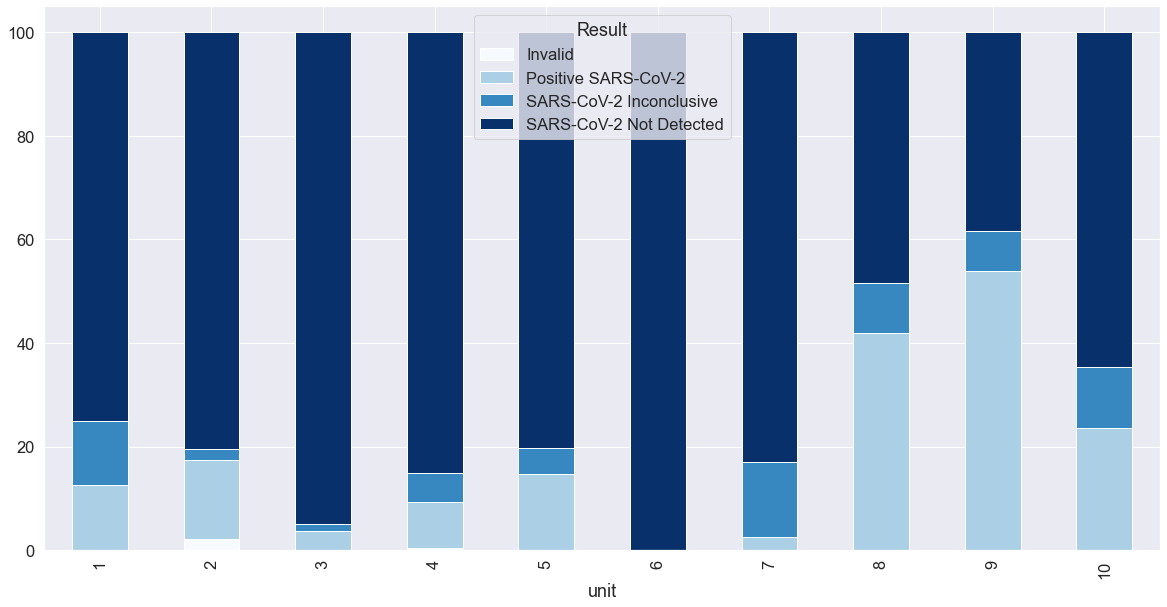

In [596]:
sns.set(font_scale = 1.5)
(pd.crosstab(aero['unit'], aero['Result'], normalize = 'index')*100).plot(kind='bar', stacked = True,
                                                                          figsize = (20,10),cmap='Blues')

<AxesSubplot:xlabel='unit', ylabel='Result'>

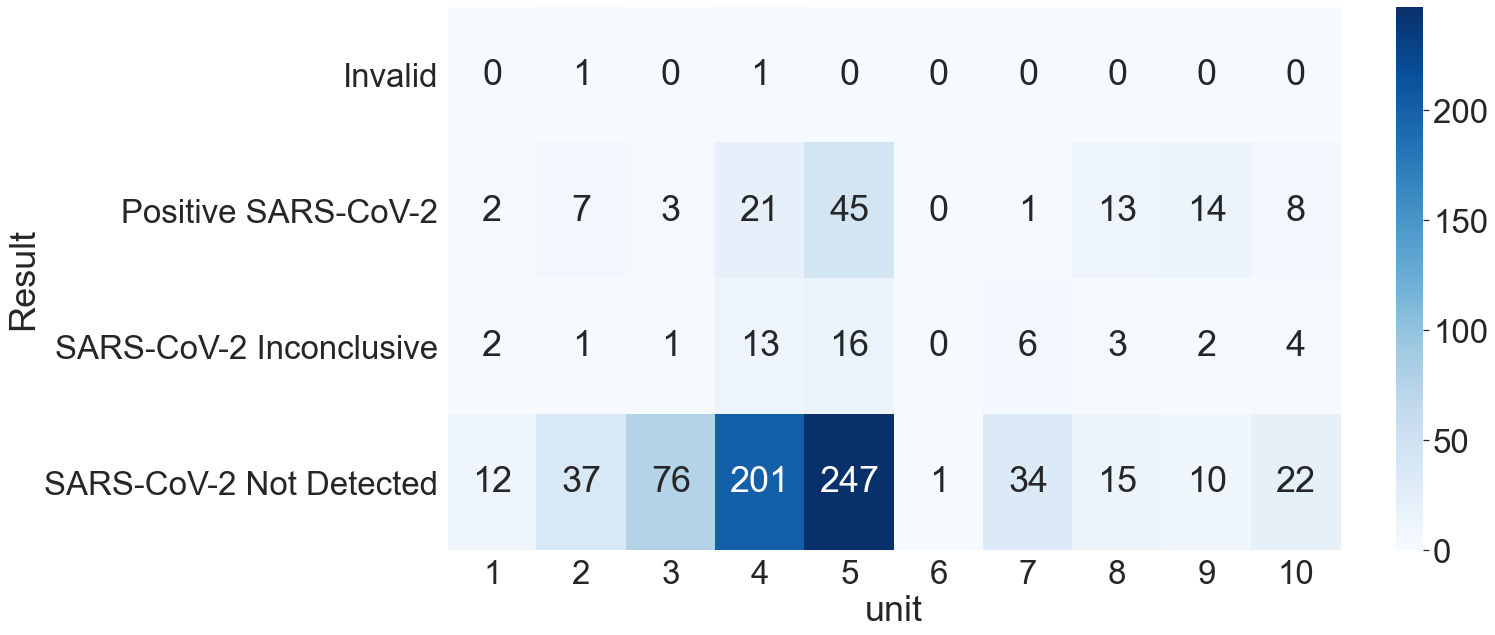

In [597]:
plt.figure(figsize = (20,10))
sns.set(font_scale = 3)
sns.heatmap(pd.crosstab(index=aero['Result'], columns= aero['unit']), annot=True, cmap='Blues',fmt='g')

### Notes:
- The stacked barplot gives the relative percentage of results found at each unit.
- The heatmap gives the counts of each result at each unit.
- Units 4 and 5 have the most observations.
- Unit 6 only has 1 observation.
- Number of Invalid and Inconclusive are generally (relatively) low and not particularly informative.
- Next steps are to remove Invalid and Inconclusive Results to focus on Pos/Neg.
- We will also remove SID since its unique for each observation.

In [598]:
aero = pd.get_dummies(data=aero, columns = ['Result'])
aero = aero.drop(['Result_Invalid','Result_SARS-CoV-2 Inconclusive','Result_SARS-CoV-2 Not Detected','SID'], axis=1)
aero = aero.rename(columns = {'Result_Positive SARS-CoV-2':'pos', 'Result_SARS-CoV-2 Not Detected':'neg'})

### Notes:
- The get dummies function for positives automatically generated 1=positive and a 0=negative, thus we will also remove the negatives column
- We can evaluate the turn around time from the collection and resulted datetimes.

In [600]:
time_diff = aero['resulted']-aero['collection']
aero['TAT'] = time_diff.dt.total_seconds()/(60*60*24)

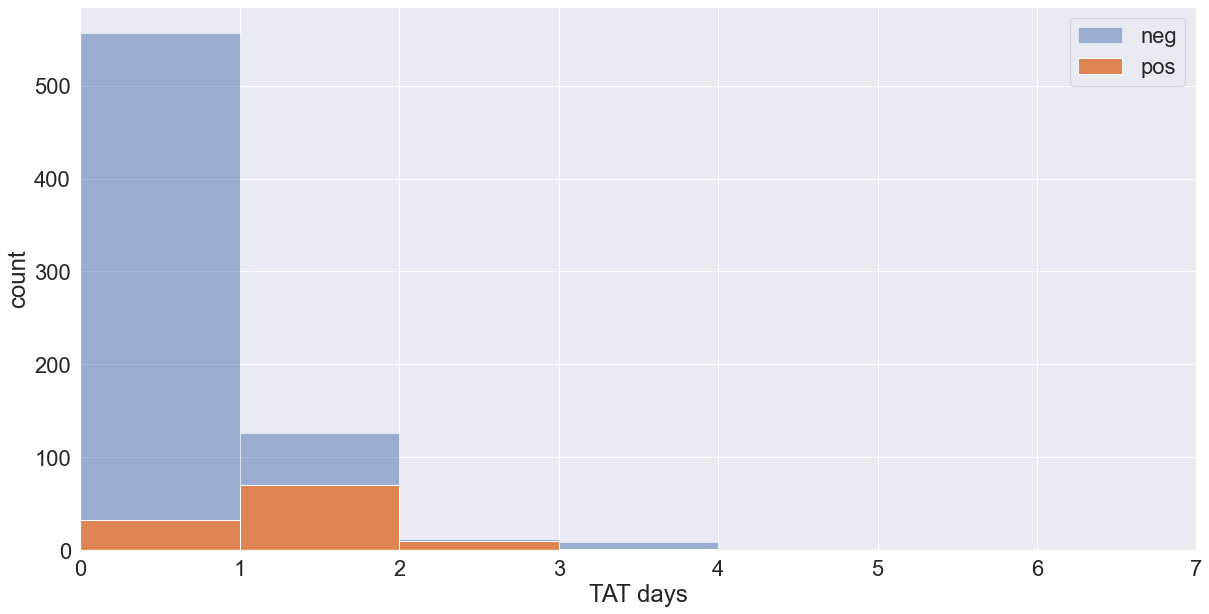

In [604]:
plt.figure(figsize = (20,10))
sns.set(font_scale = 2)

plt.hist(aero.loc[aero['pos'] == 0,'TAT'], 
 label = 'neg',bins = range(0,10,1), alpha = 0.5)
plt.hist(aero.loc[aero['pos'] == 1,'TAT'], 
 label = 'pos',bins = range(0,10,1), alpha =1)
plt.legend()
plt.xlabel('TAT days')
plt.ylabel('count')
plt.xlim(0,7)
plt.show()

### Notes:
- Above histogram depicts turn around time for neg and pos - positives take relatively longer to result, but this may be due to repeat testing.
- Perhpas we can inspect the positive counts per week for each unit?

In [605]:
aero['col_week'] = aero['collection'].dt.isocalendar().week

In [620]:
lsta = list(np.arange(17,52))
lstb = list(np.arange(1,17))
wks_of_year = lsta+lstb

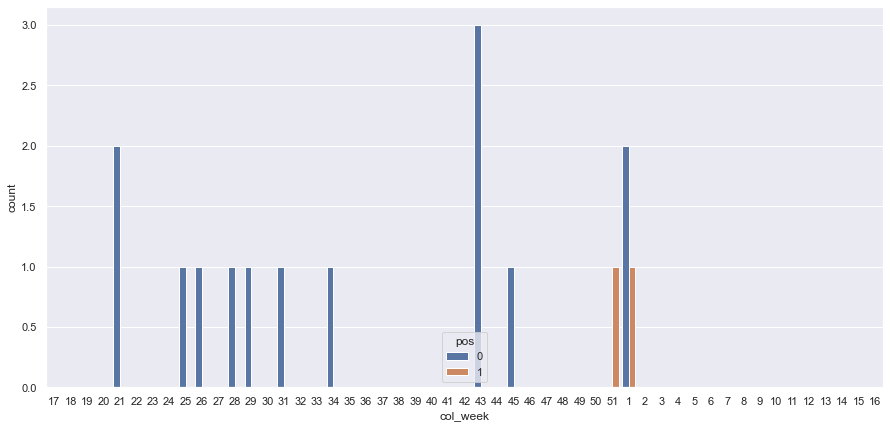

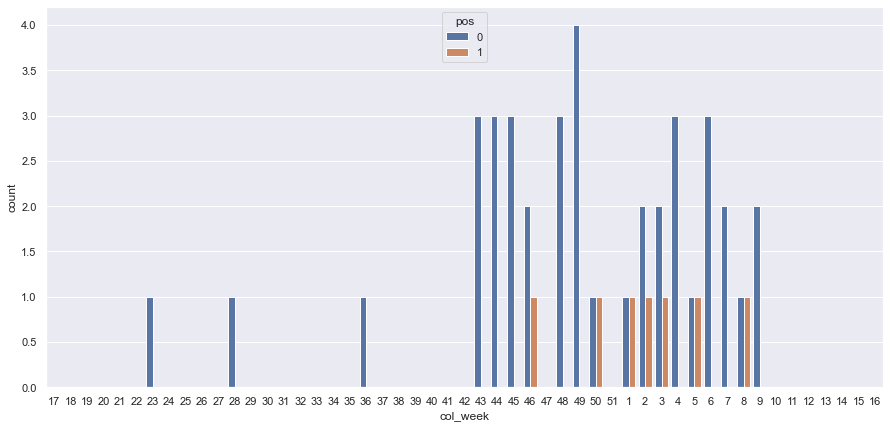

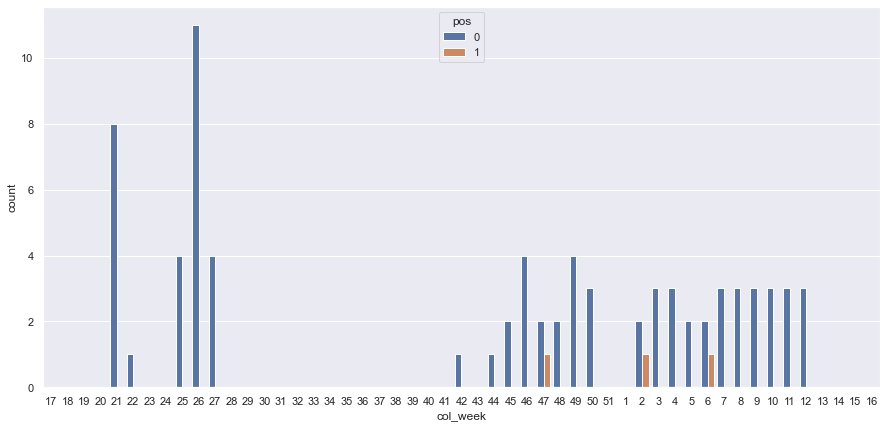

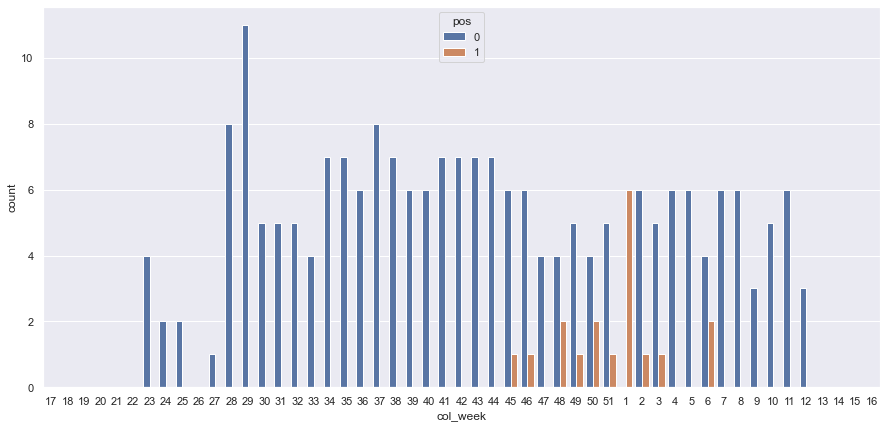

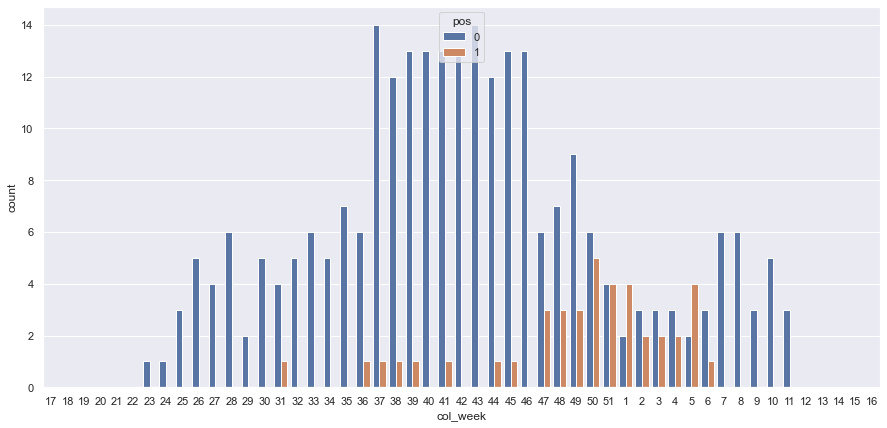

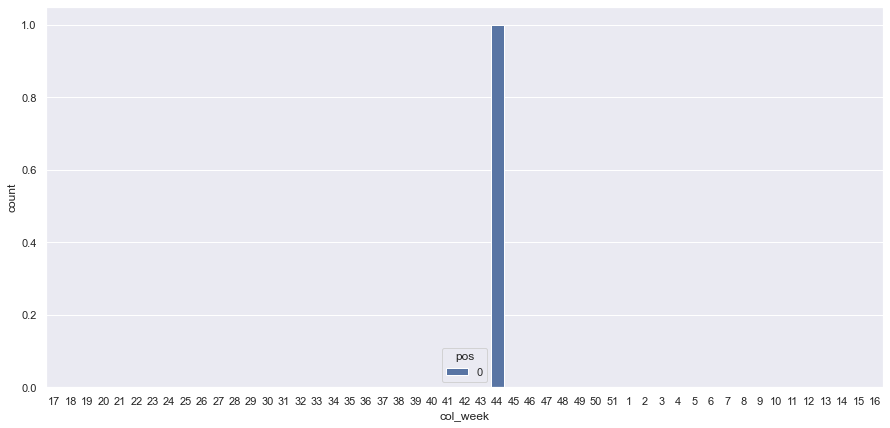

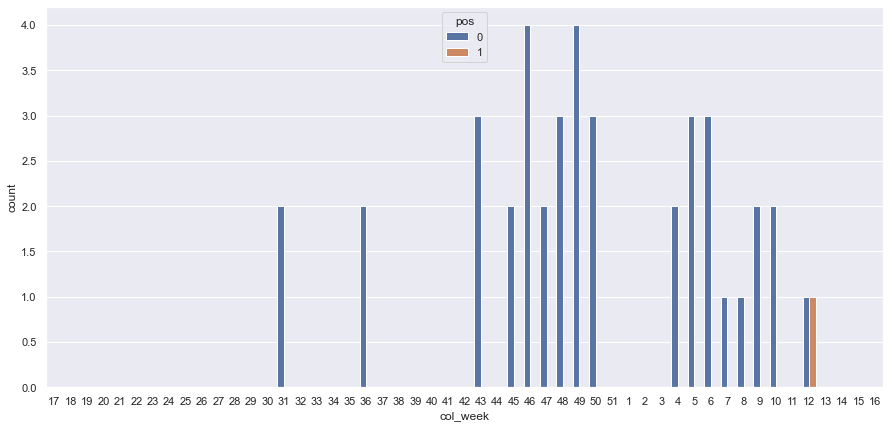

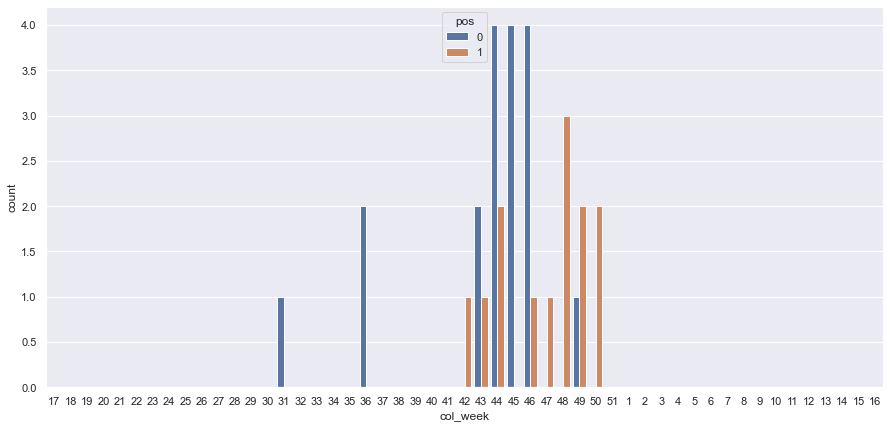

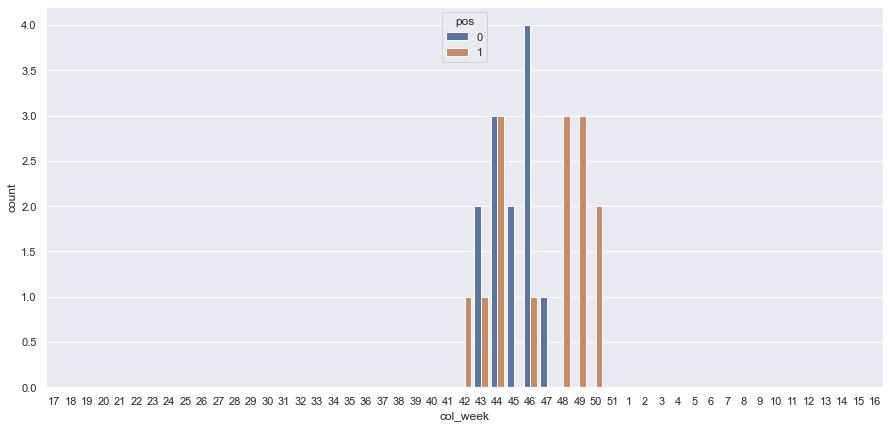

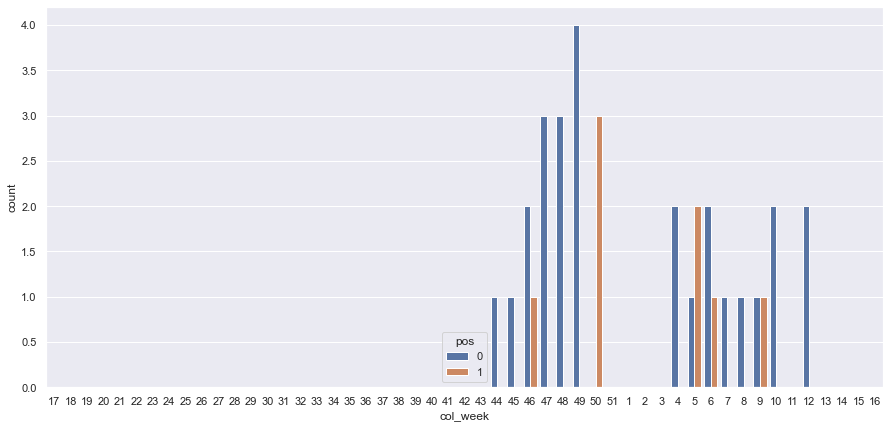

In [631]:
i = 1
while i <= 10:
    plt.figure(figsize = (15,7))
    sns.set(font_scale = 1)
    d = aero[aero['unit']==i]
    sns.countplot(x='col_week', hue='pos', data=d, order = wks_of_year)
    i += 1

### Notes:
- In ascending order, the charts start with unit 1 and end with unit 10 - sorry i could not figure out how to insert a looping title.
- The data spans from May 2021 (week 17) to April 2022 (week 16).
- Units 1, 2, 3, 4, & 5 appear to have detected positives aroud the same time, weeks 48-7.
- Units 8, 9, and 10 appear also to share some similarity around weeks 42-51.

## Logistic Regression
- Logistic regression is a modeling techinque that can evluate certain independent factors on an outcome
- in this case, the outcome (or dependent variable) will be pos/neg
- the independent variables, or factors, will be the unit and the collection week, because the location of the unit and time of year are probably very important to the number of positives detected.

In [537]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [693]:
X = aero.drop(columns=['pos','collection','resulted', 'TAT']).pivot(columns='unit')['col_week'].fillna(value = 0)
Y = aero['pos']

In [701]:
# Define Logistic Regression model 
log_reg= LogisticRegression(penalty='none', random_state=1, max_iter = 1000)
# Fit the model
log_reg.fit(X, Y)

LogisticRegression(max_iter=1000, penalty='none', random_state=1)

In [702]:
pd.Series(log_reg.coef_[0], index = X.columns).sort_values(ascending = False)

unit
9     0.041061
8     0.032102
10    0.010732
5    -0.003608
1    -0.008958
2    -0.012684
4    -0.019564
3    -0.064583
7    -0.097367
6    -0.261967
dtype: float64

In [703]:
# Finding the odds
odds = np.exp(log_reg.coef_[0]) 

# Adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X.columns, columns = ['odds']).sort_values(by = 'odds', ascending = False) 

,odds
unit,
9,1.041915
8,1.032623
10,1.010790
5,0.996399
1,0.991082
2,0.987396
4,0.980626
3,0.937459
7,0.907223


### Notes:
- If this modeling is accurate, the results indicate the locations where units 9, 8, and 10 were placed had a 4.1%, 3.2%, and 1.1% more likely chance of detecing aerosolized SARS-CoV-2.
- Likewise, only locations of units 6 and perhpas 7 appears the least likely to detect virus.
- The locations of units 5, 1, 2, 4, and 3 odds ratios do not indicate much deviation from random chance.
- These results may be potentially false - I could set up training/test sets to verify - there may be better ways to model as well. :)